In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import pickle
import math

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
base_path = './drive/My Drive/Colab Notebooks/hw4/variational-autoencoder/'
train_path = base_path + 'hw4_tr7.pkl'
test_path = base_path + 'hw4_te7.pkl'

base_path_model = base_path + 'model/'

In [0]:
with open(train_path, 'rb') as f:
  train = pickle.load(f)

with open(test_path, 'rb') as f:
  test = pickle.load(f)

In [7]:
train.shape

(6265, 28, 28)

In [8]:
test.shape

(1028, 28, 28)

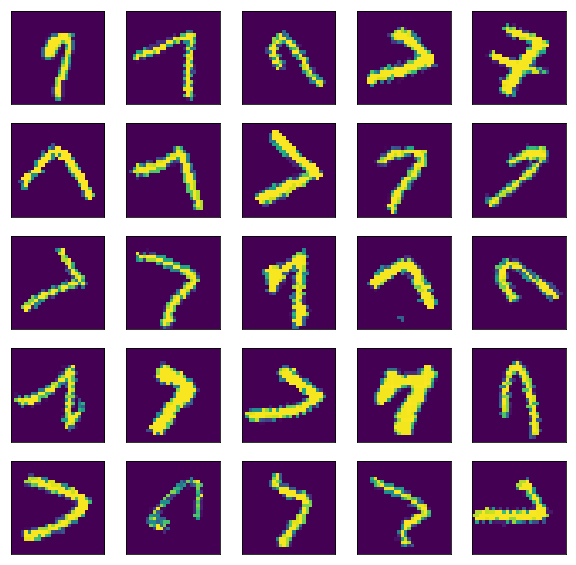

In [9]:
plt.figure(figsize=(10, 10))
for i in range(5):
  for j in range(5):
    ax = plt.subplot(5, 5, 5 * i + j + 1)
    plt.imshow(train[np.random.randint(0, train.shape[0])])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
n_gaussians = 5

def encoder(X):
  conv_1 = tf.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu)(X)
  pool_1 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(conv_1)
  bn_1 = tf.layers.BatchNormalization()(pool_1)
  
  dropout_1 = tf.layers.Dropout(rate=0.4)(bn_1)
  
  flattened = tf.layers.Flatten()(dropout_1)
  mu = tf.layers.Dense(units=n_gaussians * 2)

In [0]:
X = tf.placeholder(dtype='float', shape=[None, 28, 28, 1], name='X')
Y = tf.placeholder(dtype='float', shape=[None, 28, 28, 1], name='Y')

In [0]:
n_gaussians = 5

conv_1 = tf.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(X)
# pool_1 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_1)
# bn_1 = tf.layers.BatchNormalization()(conv_1)

conv_2 = tf.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(conv_1)
# pool_2 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# bn_2 = tf.layers.BatchNormalization()(conv_2)

conv_3 = tf.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu, padding='same')(conv_2)
# pool_3 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_3)
# bn_3 = tf.layers.BatchNormalization()(conv_3)

dropout_1 = tf.layers.Dropout(rate=0.4)(conv_3)

flattened = tf.layers.Flatten()(dropout_1)
dense_1 = tf.layers.Dense(units=n_gaussians * 2)(flattened)

# use first half as mu
mu = dense_1[:, :n_gaussians]

# use 2nd half as std, standard deviation has to be positive
std = tf.nn.softplus(dense_1[:, n_gaussians:])

In [84]:
flattened

<tf.Tensor 'flatten_14/Reshape:0' shape=(?, 128) dtype=float32>

In [85]:
print(conv_1)
print(conv_2)
print(conv_3)

Tensor("conv2d_32/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("conv2d_33/Relu:0", shape=(?, 7, 7, 8), dtype=float32)
Tensor("conv2d_34/Relu:0", shape=(?, 4, 4, 8), dtype=float32)


In [86]:
mu

<tf.Tensor 'strided_slice_18:0' shape=(?, 5) dtype=float32>

In [87]:
std

<tf.Tensor 'Softplus_9:0' shape=(?, 5) dtype=float32>

In [0]:
# take sample
z = mu + std * tf.random.normal(tf.shape(mu))

In [89]:
z

<tf.Tensor 'add_3:0' shape=(?, 5) dtype=float32>

In [90]:
dense_2 = tf.layers.Dense(units=n_gaussians * 2, activation=tf.nn.relu)(z)
dense_2

<tf.Tensor 'dense_13/Relu:0' shape=(?, 10) dtype=float32>

In [91]:
dense_3 = tf.layers.Dense(units=3 * 3 * 8, activation=tf.nn.relu)(dense_2)
dense_3

<tf.Tensor 'dense_14/Relu:0' shape=(?, 72) dtype=float32>

In [103]:
reshaped = tf.reshape(dense_3, [-1, 3, 3, 8])
reshaped

<tf.Tensor 'Reshape_4:0' shape=(?, 3, 3, 8) dtype=float32>

In [104]:
dconv_1 = tf.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu, padding='same')(reshaped)
dconv_1

<tf.Tensor 'conv2d_transpose_15/Relu:0' shape=(?, 6, 6, 8) dtype=float32>

In [105]:
dconv_2 = tf.layers.Conv2DTranspose(filters=8, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')(dconv_1)
dconv_2

<tf.Tensor 'conv2d_transpose_16/Relu:0' shape=(?, 12, 12, 8) dtype=float32>

In [106]:
flattened_2 = tf.layers.Flatten()(dconv_2)
flattened_2

<tf.Tensor 'flatten_17/Reshape:0' shape=(?, 1152) dtype=float32>

In [107]:
dense_4 = tf.layers.Dense(units=28 * 28, activation=tf.nn.relu)(flattened)
dense_4

<tf.Tensor 'dense_15/Relu:0' shape=(?, 784) dtype=float32>

In [109]:
output = tf.reshape(dense_4, [-1, 28, 28, 1])
output

<tf.Tensor 'Reshape_6:0' shape=(?, 28, 28, 1) dtype=float32>